In [ ]:
#pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

# Initialize Spark session
spark = SparkSession.builder.appName("AccidentSeverityPrediction").getOrCreate()

# Load the data
data = spark.read.csv("accident_vehicals.csv", header=True, inferSchema=True)

# Inspect the data
data.printSchema()
data.show(5)

# Count null values in each column
data.select([col(c).isNull().cast("int").alias(c) for c in data.columns]).groupBy().sum().show()


root
 |-- Accident_Index: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: double (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Number: double (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Carriageway_Hazards: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: double (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Local_Authority_(District): string (nullable = true)
 |-- Local_Authority_(Highway): string (nullable = true)
 |-- Location_Easting_OSGR: double (nullable = true)
 |-- Location_Northing_OSGR: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- LSOA_of_Accident_Location: string (nullable = true)
 |-- Num

In [60]:
from pyspark.ml.feature import StringIndexer

# Convert Accident_Severity to indexed values
severity_indexer = StringIndexer(inputCol="Accident_Severity", outputCol="Accident_Severity_Indexed")
data = severity_indexer.fit(data).transform(data)


In [61]:
data = data.na.drop()


In [62]:
# Convert Weather_Conditions to indexed values
weather_indexer = StringIndexer(inputCol="Weather_Conditions", outputCol="Weather_Conditions_Indexed")
data = weather_indexer.fit(data).transform(data)


In [63]:
from pyspark.ml.feature import VectorAssembler

# Assemble features into a single vector
assembler = VectorAssembler(
    inputCols=["Speed_limit", "Number_of_Vehicles", "Weather_Conditions_Indexed",'Age_of_Vehicle','Engine_Capacity_CC','Vehicle_Location_Restricted_Lane','Latitude','Longitude'], 
    outputCol="features"
)
data = assembler.transform(data)


In [64]:
data.select("features", "Accident_Severity_Indexed").show(10, truncate=False)


+-------------------------------------------------+-------------------------+
|features                                         |Accident_Severity_Indexed|
+-------------------------------------------------+-------------------------+
|[30.0,2.0,0.0,4.0,1598.0,0.0,51.490536,-0.173827]|0.0                      |
|[30.0,2.0,0.0,2.0,999.0,0.0,51.490536,-0.173827] |0.0                      |
|[30.0,2.0,0.0,9.0,1596.0,0.0,51.495892,-0.171308]|0.0                      |
|[30.0,2.0,0.0,3.0,125.0,0.0,51.498245,-0.201326] |0.0                      |
|[30.0,2.0,1.0,4.0,2198.0,0.0,51.518349,-0.216389]|2.0                      |
|[30.0,2.0,1.0,1.0,1968.0,0.0,51.497822,-0.179731]|0.0                      |
|[30.0,2.0,2.0,4.0,125.0,0.0,51.501668,-0.184189] |2.0                      |
|[30.0,1.0,1.0,3.0,2143.0,0.0,51.514787,-0.195197]|1.0                      |
|[30.0,2.0,0.0,2.0,3498.0,0.0,51.489305,-0.175605]|1.0                      |
|[30.0,2.0,1.0,9.0,2148.0,0.0,51.505874,-0.194541]|0.0          

In [65]:
#ndfbhrbhdbvhgfdvnds sdbfrhfdbvb rhbfr jsbfze,nbhjhsbdffz fbez vd vsbdvbnv dbv vdvbdbds vnd vhjdsbvs  
from pyspark.sql.functions import when, lit

# Step 1: Calculate class frequencies
class_counts = data.groupBy("Accident_Severity_Indexed").count().collect()

# Step 2: Map class frequencies to weights
total_count = sum(row['count'] for row in class_counts)
class_weights = {
    row['Accident_Severity_Indexed']: total_count / row['count']
    for row in class_counts
}

# Step 3: Add a `class_weights` column to the dataset
data = data.withColumn(
    "class_weights",
    when(data["Accident_Severity_Indexed"] == 0.0, lit(class_weights[0.0]))
    .when(data["Accident_Severity_Indexed"] == 1.0, lit(class_weights[1.0]))
    .otherwise(lit(class_weights[2.0]))
)

# Verify the dataset
data.select("Accident_Severity_Indexed", "class_weights").show()


+-------------------------+------------------+
|Accident_Severity_Indexed|     class_weights|
+-------------------------+------------------+
|                      0.0| 1.149751798639813|
|                      0.0| 1.149751798639813|
|                      0.0| 1.149751798639813|
|                      0.0| 1.149751798639813|
|                      2.0|161.94147843942505|
|                      0.0| 1.149751798639813|
|                      2.0|161.94147843942505|
|                      1.0| 8.059836484414921|
|                      1.0| 8.059836484414921|
|                      0.0| 1.149751798639813|
|                      1.0| 8.059836484414921|
|                      2.0|161.94147843942505|
|                      2.0|161.94147843942505|
|                      2.0|161.94147843942505|
|                      0.0| 1.149751798639813|
|                      0.0| 1.149751798639813|
|                      0.0| 1.149751798639813|
|                      0.0| 1.149751798639813|
|            

In [66]:
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [67]:
train_data.groupBy("Accident_Severity_Indexed").count().show()


+-------------------------+------+
|Accident_Severity_Indexed| count|
+-------------------------+------+
|                      0.0|109576|
|                      1.0| 15691|
|                      2.0|   787|
+-------------------------+------+



In [68]:
#nefhfhyrefhbdhcjzbczebfbfbehjff cebfebfgefvhjbfeb hjerbjefffhbfcnnjdfjkhfefbe zefjbfbf,nrzejfbndsblqfebf
from pyspark.ml.classification import LogisticRegression

# Initialize the Logistic Regression model
lr = LogisticRegression(
    featuresCol="features",
    labelCol="Accident_Severity_Indexed",
    weightCol="class_weights"
)

# Train the model
lr_model = lr.fit(train_data)


In [69]:
# Make predictions
predictions = lr_model.transform(test_data)

# Show predictions
predictions.select("features", "Accident_Severity_Indexed", "prediction").show(3000)

# Evaluate accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity_Indexed", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")


+--------------------+-------------------------+----------+
|            features|Accident_Severity_Indexed|prediction|
+--------------------+-------------------------+----------+
|[30.0,2.0,0.0,9.0...|                      0.0|       0.0|
|[30.0,2.0,2.0,4.0...|                      2.0|       0.0|
|[30.0,2.0,0.0,2.0...|                      1.0|       0.0|
|[30.0,2.0,1.0,12....|                      2.0|       0.0|
|[30.0,2.0,0.0,2.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,1.0...|                      1.0|       0.0|
|[30.0,2.0,0.0,1.0...|                      0.0|       0.0|
|[30.0,1.0,1.0,4.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,2.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,4.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,4.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,3.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,9.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,11....|                  

In [70]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="Accident_Severity_Indexed", featuresCol="features", numTrees=50,weightCol="class_weights")
rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)


In [71]:
# Make predictions
predictions = rf_model.transform(test_data)

# Show predictions
predictions.select("features", "Accident_Severity_Indexed", "prediction").show(100)

# Evaluate accuracy
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity_Indexed", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")


+--------------------+-------------------------+----------+
|            features|Accident_Severity_Indexed|prediction|
+--------------------+-------------------------+----------+
|[30.0,2.0,0.0,9.0...|                      0.0|       0.0|
|[30.0,2.0,2.0,4.0...|                      2.0|       1.0|
|[30.0,2.0,0.0,2.0...|                      1.0|       0.0|
|[30.0,2.0,1.0,12....|                      2.0|       0.0|
|[30.0,2.0,0.0,2.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,1.0...|                      1.0|       0.0|
|[30.0,2.0,0.0,1.0...|                      0.0|       0.0|
|[30.0,1.0,1.0,4.0...|                      0.0|       2.0|
|[30.0,2.0,0.0,2.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,4.0...|                      0.0|       1.0|
|[30.0,2.0,0.0,4.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,3.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,9.0...|                      0.0|       0.0|
|[30.0,2.0,0.0,11....|                  

In [72]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Accident_Severity_Indexed", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Accuracy: 0.6403699845313634
Precision: 0.8127904942246497
Recall: 0.6403699845313634
F1 Score: 0.7144882179174997


In [73]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Step 1: Predictions on training data
train_predictions = rf_model.transform(train_data)

# Step 2: Predictions on test data
test_predictions = rf_model.transform(test_data)

# Step 3: Initialize the evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity_Indexed", 
    predictionCol="prediction", 
    metricName="accuracy"
)

# Step 4: Calculate accuracy
train_accuracy = evaluator.evaluate(train_predictions)
test_accuracy = evaluator.evaluate(test_predictions)

# Step 5: Print results
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

# Step 6: Compare
if train_accuracy > test_accuracy:
    print("The model might be overfitting. Consider regularization or simpler models.")
elif train_accuracy < test_accuracy:
    print("The model might be underfitting. Consider adding features or using a more complex model.")
else:
    print("The model generalizes well between training and test data.")


Training Accuracy: 0.6416535770384121
Test Accuracy: 0.6403699845313634
The model might be overfitting. Consider regularization or simpler models.


In [74]:
from pyspark.ml.tuning import ParamGridBuilder

# Create a parameter grid for Logistic Regression
param_grid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(lr.maxIter, [10, 50, 100]) \
    .build()


In [75]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Define the evaluator (use accuracy for classification problems)
evaluator = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity_Indexed", 
    predictionCol="prediction", 
    metricName="accuracy"
)

# Create a cross-validator
cross_validator = CrossValidator(
    estimator=rf,  # Logistic Regression model
    estimatorParamMaps=param_grid,  # Parameter grid
    evaluator=evaluator,  # Evaluator
    numFolds=5,  # Number of folds in cross-validation
    seed=42  # Random seed for reproducibility
)


In [76]:
# Fit the cross-validator to the training data
cv_model = cross_validator.fit(train_data)


In [77]:
# Extract the best model from cross-validation
best_model = cv_model.bestModel

# Make predictions on the test data
cv_predictions = best_model.transform(test_data)

# Evaluate test accuracy
test_accuracy = evaluator.evaluate(cv_predictions)

print(f"Cross-Validated Test Accuracy: {test_accuracy}")


Cross-Validated Test Accuracy: 0.6403699845313634


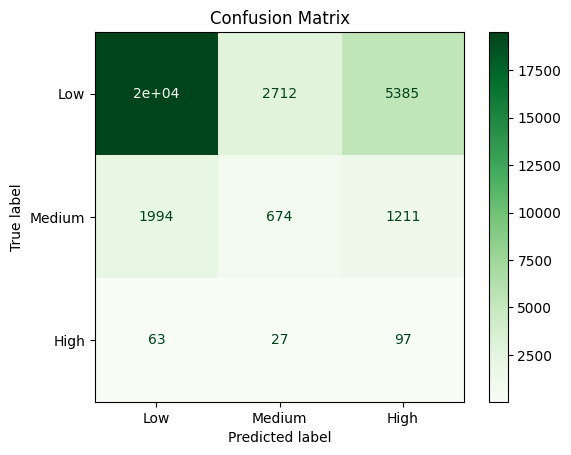

In [78]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Convert predictions to pandas for easier handling
predictions_df = predictions.select("Accident_Severity_Indexed", "prediction").toPandas()

# Compute confusion matrix
cm = confusion_matrix(predictions_df["Accident_Severity_Indexed"], predictions_df["prediction"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])

# Plot confusion matrix
disp.plot(cmap=plt.cm.Greens)
plt.title("Confusion Matrix")
plt.show()


In [79]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Evaluate predictions
evaluator = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity_Indexed",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy: {accuracy:.4f}")

# Evaluate weighted precision and recall
precision_evaluator = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity_Indexed",
    predictionCol="prediction",
    metricName="weightedPrecision"
)
precision = precision_evaluator.evaluate(predictions)

recall_evaluator = MulticlassClassificationEvaluator(
    labelCol="Accident_Severity_Indexed",
    predictionCol="prediction",
    metricName="weightedRecall"
)
recall = recall_evaluator.evaluate(predictions)

print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall: {recall:.4f}")


Accuracy: 0.6404
Weighted Precision: 0.8128
Weighted Recall: 0.6404


In [80]:
from pyspark.sql.functions import col

# Extract true and predicted labels
results = predictions.select("Accident_Severity_Indexed", "prediction")

# Count the occurrences for true values
true_counts = results.groupBy("Accident_Severity_Indexed").count().withColumnRenamed("count", "true_count")

# Count the occurrences for predicted values
predicted_counts = results.groupBy("prediction").count().withColumnRenamed("count", "predicted_count")

# Merge the counts
comparison = true_counts.join(predicted_counts, 
                              true_counts["Accident_Severity_Indexed"] == predicted_counts["prediction"], 
                              "outer").select(
    col("Accident_Severity_Indexed").alias("class"), 
    "true_count", 
    "predicted_count"
)

# Fill nulls with 0 for any missing classes
comparison = comparison.fillna(0, subset=["true_count", "predicted_count"])

# Collect the data for visualization
comparison_data = comparison.collect()


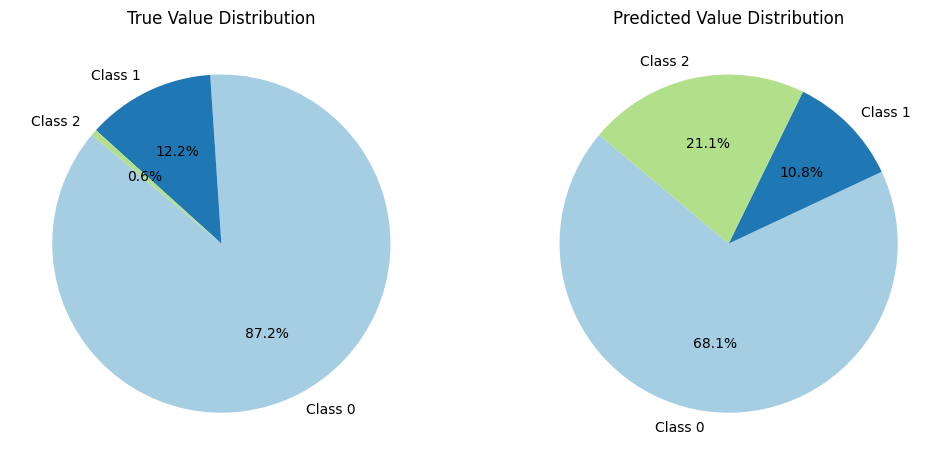

In [81]:
import matplotlib.pyplot as plt

# Convert the collected data to a dictionary
true_data = {int(row['class']): row['true_count'] for row in comparison_data if row['class'] is not None}
predicted_data = {int(row['class']): row['predicted_count'] for row in comparison_data if row['class'] is not None}

# Labels and counts for the pie charts
labels = list(true_data.keys())
true_counts = list(true_data.values())
predicted_counts = list(predicted_data.values())

# Define labels
labels = [f"Class {int(c)}" for c in labels]

# Plot True Values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(true_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("True Value Distribution")

# Plot Predicted Values
plt.subplot(1, 2, 2)
plt.pie(predicted_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired.colors)
plt.title("Predicted Value Distribution")

plt.show()


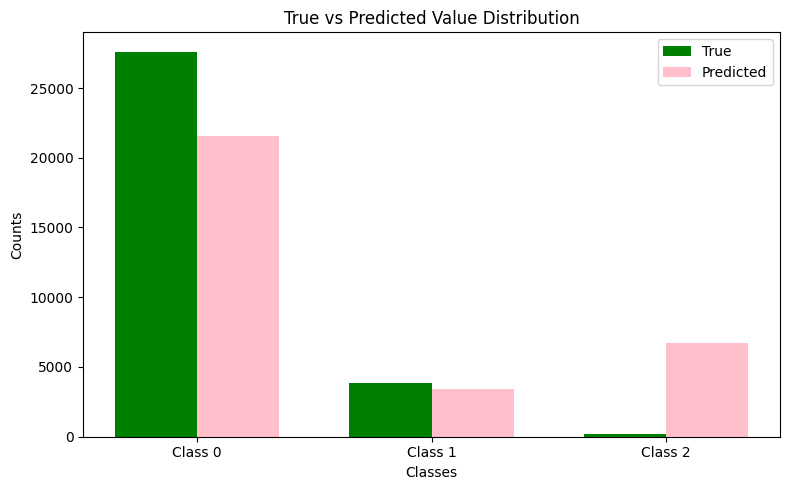

In [82]:
import numpy as np

# Data preparation
x = np.arange(len(labels))  # class labels
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, true_counts, bar_width, label='True', color='green')
plt.bar(x + bar_width/2, predicted_counts, bar_width, label='Predicted', color='pink')

# Labels and formatting
plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("True vs Predicted Value Distribution")
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()
